# Первоначальный анализ входных данных

---

### Цели

1. Сформировать общее представление o датасете у всей команды. 
2. Оценить качество исходных данных для модели.
3. Наметить подход для дополнительной обработки данных в случае необходимости.

In [1]:
import json
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import pprint
import re
import seaborn as sns
import time
import warnings

In [2]:
plt.style.use('ggplot')
rcParams['font.family'] = 'monospace'
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
%matplotlib inline

In [3]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

##### Вся информация находится в 3-х файлах:
 - dataset_news_1.xlsx = факт просмотра пользователем новости с привязкой к дате
 - news.json = расширенная информация о новостях
 - districts.json = информация по округам г. Москвы

## Датасет

In [4]:
dataset = pd.read_excel(os.path.join(BASE_DIR, 'data', 'dataset_news_1.xlsx'))

#### Общая справка

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26446 entries, 0 to 26445
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  26446 non-null  datetime64[ns]
 1   url_clean  26446 non-null  object        
 2   user_id    26446 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 620.0+ KB


#### Посещаемость новостного портала

In [6]:
plt.style.use('ggplot')

In [7]:
users_per_hour = dataset.groupby(pd.Grouper(freq="1H", key="date_time"))['user_id'].count()

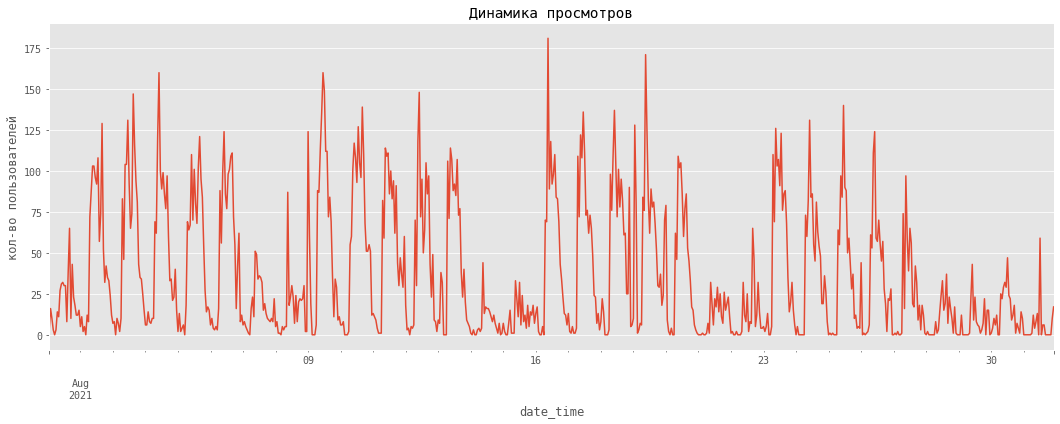

In [8]:
ax = users_per_hour.plot(title="Динамика просмотров", ylabel="кол-во пользователей", figsize=(18, 6))

##### Ожидаемые скачки в посещаемости днём и снижения ночью. Немного странно, что есть существенные "провалы" по выходным... Возможно это явление характерно для летнего периода, когда люди выходной стараются провести на природе/даче и т.д. Также, возможно это связано с какими-то особенностями аудитории новостного раздела. Надо поизучать.  Возможно стоит учесть этот момент для рекоммендательной модели. Например, на неделе фокус на услугах, полезной информации для определённого административного округа, политике.. а на выходных - культура, актуальные события и т.д.

#### Пользователи

In [9]:
# кол-во уникальных
dataset.user_id.nunique()

239

In [10]:
user_habbits = pd.pivot_table(data=dataset, values='url_clean', columns=pd.Grouper(key='date_time', freq='1D'), index='user_id', aggfunc="count", margins_name="Total")
user_habbits['days_active'] = [vals.count() for i, vals in user_habbits.iterrows()]
user_habbits['total_reads'] = [vals.sum() for i, vals in user_habbits.iterrows()]
user_habbits['avg_reads'] = user_habbits.total_reads / user_habbits.days_active

In [11]:
sns.set(rc={'font.family': 'monospace'})

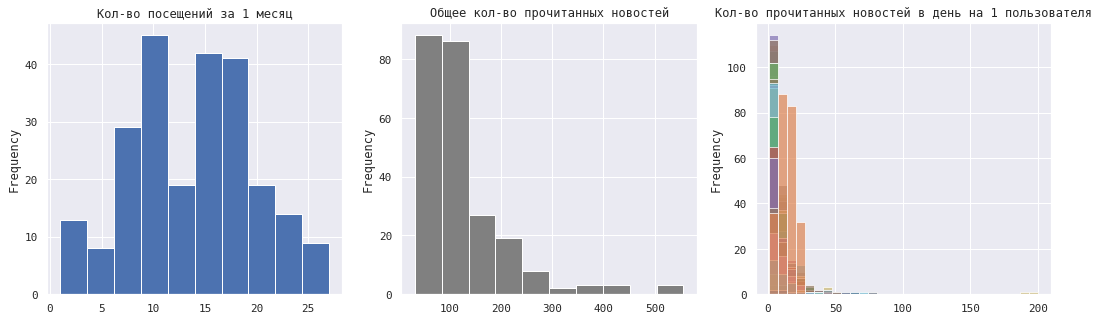

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
user_habbits['days_active'].plot(kind='hist', title='Кол-во посещений за 1 месяц', ax=ax[0])
user_habbits['total_reads'].plot(kind='hist', title='Общее кол-во прочитанных новостей', ax=ax[1], color='grey')
user_habbits.iloc[:, :-2].plot(kind='hist', title='Кол-во прочитанных новостей в день на 1 пользователя', ax=ax[2], legend=False, alpha=0.7, bins=30)
plt.show()

##### Пока не очень ясно как можно это прокомментировать... 
1. многие люди посещают сайт регулярно. 
2. обычно просматривают меньше 10 новостей.
3. интересно будет посмотреть сколько они проводят времени на сайте.

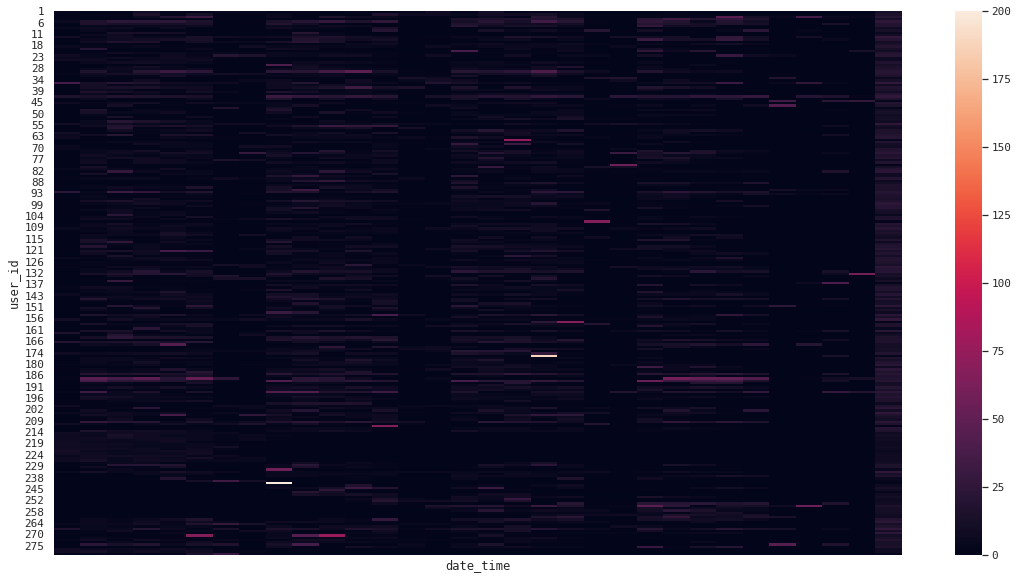

In [13]:
fig, ax = plt.subplots(figsize=(19,10))
ax = sns.heatmap(user_habbits.iloc[:, :-2].fillna(0), xticklabels=False)

##### Есть и те, для кого не бывает "слишком много новостей". Но их немного

## Новости

In [14]:
df_news = pd.read_json(os.path.join(BASE_DIR, 'data', 'news.json'))

In [15]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       6554 non-null   int64         
 1   title                    6554 non-null   object        
 2   importance               4673 non-null   object        
 3   published_at             6554 non-null   datetime64[ns]
 4   created_at               6554 non-null   datetime64[ns]
 5   updated_at               6554 non-null   datetime64[ns]
 6   is_deferred_publication  5729 non-null   float64       
 7   status                   6554 non-null   object        
 8   ya_rss                   6554 non-null   int64         
 9   active_from              0 non-null      float64       
 10  active_to                0 non-null      float64       
 11  oiv_id                   5714 non-null   float64       
 12  search                   6554 non-

In [16]:
with open(os.path.join(BASE_DIR, 'data/news.json'), 'r') as file:
    news = json.loads(file.read())

In [17]:
# пример одной новости
pprint.pprint(news[1])

{'active_from': None,
 'active_from_timestamp': False,
 'active_to': None,
 'active_to_timestamp': False,
 'attach': [],
 'canonical_updated_at': '2021-09-21 12:52:45',
 'canonical_url': None,
 'counter': None,
 'created_at': '2020-09-25 16:49:20',
 'created_at_timestamp': 1601041760,
 'date': '2020-09-26 09:02:00',
 'date_timestamp': '1601100120',
 'display_image': 1,
 'full_text': '<p>С 26 сентября по 5 октября закрылся участок '
              'Арбатско-Покровской линии от станции метро '
              '&laquo;Молодежная&raquo; до &laquo;Парка Победы&raquo;. Для '
              'пассажиров организованы компенсационные автобусы (КМ).</p>\n'
              '<p>Они следуют от &laquo;Молодежной&raquo; через '
              '&laquo;Кунцевскую&raquo; и &laquo;Славянский бульвар&raquo; до '
              '&laquo;Парка Победы&raquo;. С 05:00 до 01:55 будут курсировать '
              '132 автобуса КМ с интервалами в час пик около одной минуты и в '
              'районе двух минут в течение д

### Категории

In [18]:
df_news.describe(include=['object']).T

,count,unique,top,freq
title,6554,6485,Оперштаб сообщил о новых случаях коронавируса,24
importance,4673,1,,4673
status,6554,2,public,5517
label,115,57,Кино,11
tags,6554,6099,"[{'id': 989217, 'title': 'статистика', 'create...",81
theme_ids,6554,77,[],5506
themes,6554,77,[],5506
spheres,6554,1408,"[{'id': 12299, 'title': 'Экономика и предприни...",512
sphere,6554,62,"{'id': 3299, 'title': 'Культура', 'special': 0...",937
kind,6554,2,"{'id': 'article', 'title': 'Новости', 'type': 1}",5729


небольшое количество записей содержит информацию в колонках preview, text, images. При этом, у нас есть колонки со схожими названиями: preview_text, full_text, image.

### Значения, даты, булеаны

In [19]:
df_news.describe(exclude=[object]).T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,6554.0,NaN,NaT,NaN,NaT,NaT,71433788.597345,29949637.36862,179050.0,61164573.0,85685573.0,93104573.0,95391073.0
published_at,6554,6453,2021-01-26 07:01:01,3,2011-08-29 19:42:00,2021-08-31 18:47:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,6554,6552,2021-07-05 15:09:29,2,2012-05-16 15:51:33,2021-08-31 18:19:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
updated_at,6554,4898,2020-06-11 19:33:47,1368,2020-06-11 19:33:41,2021-09-21 08:21:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_deferred_publication,5729.0,NaN,NaT,NaN,NaT,NaT,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ya_rss,6554.0,NaN,NaT,NaN,NaT,NaT,0.662344,0.472947,0.0,0.0,1.0,1.0,1.0
active_from,0.0,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active_to,0.0,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oiv_id,5714.0,NaN,NaT,NaN,NaT,NaT,8718689.00245,17115937.4935,0.0,0.0,0.0,19343090.0,103466090.0
search,6554.0,NaN,NaT,NaN,NaT,NaT,0.99939,0.024699,0.0,1.0,1.0,1.0,1.0


In [20]:
# проверим несколько записей с пустыми значениями в столбце preview
df_news[df_news.preview.isna()][['preview', 'preview_text', 'text', 'full_text', 'image', 'images']][:5]

,preview,preview_text,text,full_text,image,images
0,NaN,Электронное голосование доступно для граждан Р...,NaN,"<p>На порталах <a href=""https://www.mos.ru/pgu...","{'id': 2712459281, 'title': '', 'copyright': '...",NaN
1,NaN,Они будут следовать от станции метро «Молодежн...,NaN,<p>С 26 сентября по 5 октября закрылся участок...,"{'id': 2827575281, 'title': 'Ю. Иванко. Mos.ru...",NaN
2,NaN,"Арина Аверина победила с результатом 79,250 ба...",NaN,<p>Московские спортсменки Арина и Дина Аверины...,"{'id': 1445509281, 'title': '', 'copyright': '...",NaN
3,NaN,Новое здание появится на Волгоградском проспекте.,NaN,"<p style=""text-align: justify;"">На юго-востоке...","{'id': 3289674281, 'title': '', 'copyright': '...",NaN
4,NaN,"Фаина Рублева — о новейших технологиях, подаре...",NaN,<p>5 ноября 1929 года в Москве открылся первый...,"{'id': 2269164281, 'title': '', 'copyright': '...",NaN


In [21]:
# проверим несколько записей с пустыми значениями в столбце preview_text
df_news[df_news.preview_text.isna()][['preview', 'preview_text', 'text', 'full_text', 'image', 'images']][:5]

,preview,preview_text,text,full_text,image,images
5729,"Город развивается, перенимая опыт передовых ме...",NaN,<p>Москва не должна идти по пути вытеснения из...,NaN,"{'id': 1111291281, 'title': '', 'copyright': '...","[{'id': 1111291281, 'title': '', 'copyright': ..."
5730,"Общий объем заявок на покупку составил 79,3 ми...",NaN,<p>Москва успешно разместила трехлетние облига...,NaN,"{'id': 3071163281, 'title': 'Фото М. Мишина. П...","[{'id': 3071163281, 'title': 'Фото М. Мишина. ..."
5731,На встрече обсуждалась подготовка к съезду пар...,NaN,"<p class=""p1"">В Музее Победы на Поклонной горе...",NaN,"{'id': 3288955281, 'title': 'Фото М. Мишина. П...","[{'id': 3288955281, 'title': 'Фото М. Мишина. ..."
5732,Там можно организовать рабочие места консьерже...,NaN,<p>Правительство столицы откажется от права со...,NaN,"{'id': 3019749281, 'title': 'Фото Е. Самарина....","[{'id': 3019749281, 'title': 'Фото Е. Самарина..."
5733,Часть столичных отраслей уже достигла показате...,NaN,<p>Москва второй год подряд становится лидером...,NaN,"{'id': 2741641281, 'title': '', 'copyright': '...","[{'id': 2741641281, 'title': '', 'copyright': ..."


In [22]:
string_columns = df_news.select_dtypes(object).columns

In [23]:
string_columns

Index(['title', 'importance', 'status', 'label', 'tags', 'theme_ids', 'themes',
       'spheres', 'sphere', 'kind', 'organizations', 'attach', 'image',
       'preview_text', 'full_text', 'url', 'preview', 'text', 'images'],
      dtype='object')

In [24]:
val_columns = df_news.select_dtypes(exclude=object).columns

In [25]:
val_columns

Index(['id', 'published_at', 'created_at', 'updated_at',
       'is_deferred_publication', 'ya_rss', 'active_from', 'active_to',
       'oiv_id', 'search', 'display_image', 'icon_id', 'canonical_url',
       'canonical_updated_at', 'is_powered', 'has_image', 'date',
       'has_district', 'date_timestamp', 'theme_id', 'is_oiv_publication',
       'updated_at_timestamp', 'created_at_timestamp', 'active_from_timestamp',
       'active_to_timestamp', 'counter', 'territory_area_id',
       'territory_district_id', 'promo'],
      dtype='object')

In [26]:
df_news[string_columns] = df_news[string_columns].fillna('')

In [27]:
df_news[val_columns] = df_news[val_columns].fillna(0)

In [28]:
df_news

,id,title,importance,published_at,created_at,updated_at,is_deferred_publication,status,ya_rss,active_from,active_to,oiv_id,search,display_image,label,icon_id,canonical_url,canonical_updated_at,is_powered,has_image,date,has_district,date_timestamp,tags,theme_id,theme_ids,themes,spheres,sphere,kind,is_oiv_publication,organizations,updated_at_timestamp,created_at_timestamp,attach,active_from_timestamp,active_to_timestamp,image,counter,territory_area_id,territory_district_id,preview_text,full_text,url,preview,text,promo,images
0,75178073,Открыта запись на электронное голосование по и...,,2020-06-05 09:00:00,2020-06-04 22:14:43,2020-06-24 09:11:55,0.0,public,1,0.0,0.0,0.0,1,1,,0.0,0.0,2021-09-21 13:39:40,0,1,2020-06-05 09:00:00,0,1591336800,"[{'id': 170217, 'title': 'Конституция', 'creat...",0.0,[],[],"[{'id': 1299, 'title': 'Социальная сфера', 'sp...","{'id': 1299, 'title': 'Социальная сфера', 'spe...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[],1.592979e+09,1.591298e+09,[],0.0,0.0,"{'id': 2712459281, 'title': '', 'copyright': '...",0.0,0.0,0.0,Электронное голосование доступно для граждан Р...,"<p>На порталах <a href=""https://www.mos.ru/pgu...",/news/item/75178073/,,,0.0,
1,80375073,Для пассажиров закрытого участка Арбатско-Покр...,,2020-09-26 09:04:00,2020-09-25 16:49:20,2020-09-26 09:04:00,0.0,public,1,0.0,0.0,20882090.0,1,1,,0.0,0.0,2021-09-21 12:52:45,0,1,2020-09-26 09:02:00,1,1601100120,"[{'id': 10217, 'title': 'метро', 'created_at':...",0.0,[],[],"[{'id': 2299, 'title': 'Транспорт', 'special':...","{'id': 2299, 'title': 'Транспорт', 'special': ...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[20882090],1.601100e+09,1.601042e+09,[],0.0,0.0,"{'id': 2827575281, 'title': 'Ю. Иванко. Mos.ru...",0.0,73501.0,6500.0,Они будут следовать от станции метро «Молодежн...,<p>С 26 сентября по 5 октября закрылся участок...,/news/item/80375073/,,,0.0,
2,41116073,Москвичка Арина Аверина выиграла чемпионат Евр...,,2018-06-04 12:04:00,2018-06-04 09:51:15,2020-06-11 19:33:47,0.0,public,0,0.0,0.0,21006090.0,1,1,,0.0,0.0,2021-09-21 12:53:16,0,1,2018-06-04 12:04:00,0,1528103040,"[{'id': 332217, 'title': 'соревнования', 'crea...",0.0,[],[],"[{'id': 6299, 'title': 'Спорт', 'special': 0, ...","{'id': 6299, 'title': 'Спорт', 'special': 0, '...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[21006090],1.591893e+09,1.528095e+09,[],0.0,0.0,"{'id': 1445509281, 'title': '', 'copyright': '...",0.0,0.0,0.0,"Арина Аверина победила с результатом 79,250 ба...",<p>Московские спортсменки Арина и Дина Аверины...,/news/item/41116073/,,,0.0,
3,94978073,Многофункциональный комплекс со спортивными и ...,,2021-08-23 09:23:51,2021-08-23 09:07:27,2021-08-23 09:23:01,0.0,public_oiv,0,0.0,0.0,19180090.0,1,1,,0.0,0.0,2021-09-21 12:52:43,0,1,2021-08-23 09:23:51,1,1629699831,"[{'id': 4000217, 'title': 'Сергей Лёвкин', 'cr...",0.0,[],[],"[{'id': 4299, 'title': 'Строительство и реконс...","{'id': 4299, 'title': 'Строительство и реконст...","{'id': 'article', 'title': 'Новости', 'type': 1}",1.0,[19180090],1.629700e+09,1.629699e+09,[],0.0,0.0,"{'id': 3289674281, 'title': '', 'copyright': '...",0.0,119501.0,9500.0,Новое здание появится на Волгоградском проспекте.,"<p style=""text-align: justify;"">На юго-востоке...",/news/item/94978073/,,,0.0,
4,64742073,«По масштабам Вселенной 90 лет — это миг». Инт...,,2019-11-05 10:00:00,2019-11-01 21:28:46,2021-01-22 13:50:55,0.0,public,1,0.0,0.0,0.0,1,1,Юбилей,0.0,0.0,2021-09-21 13:39:40,0,1,2019-11-05 10:00:00,1,1572937200,"[{'id': 49217, 'title': 'интервью', 'created_a...",60287.0,"[60287, 115287]","[{'id': 60287, 'title': 'Люди города', 'create...","[{'id': 3299, 'title': 'Культура', 'special': ...","{'id': 3299, 'title': 'Культура', 'special': 0...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[],1.611313e+09,1.572633e+09,"[{'type': 'gallery', 'marker': 'gallery_1', 'd...",0.0,0.0,"{'id': 2269164281, 'title': '', 'copyright': '...",0.0,6501.0,1500.0,"Фаина Рублева — о новейших технологиях, подаре

 MEMO: перенести данные в одну колонку: preview -> preview_text, text -> full_text, images -> image

In [29]:
df_news.preview_text = df_news.apply(lambda c: c.preview if len(c.preview) > 0 else c.preview_text, axis=1)

In [30]:
df_news.full_text = df_news.apply(lambda c: c.text if len(c.text) > 0 else c.full_text, axis=1)

### Сверка наличия необходимых id в датасетах

In [31]:
dataset['news_id'] = [int(str(i[-1]).strip()) for i in dataset.url_clean.str.findall(r"(\d{4,})")]

In [32]:
dataset.news_id.fillna(0, inplace=True)

In [33]:
df_news[~df_news.id.isin(dataset.news_id.unique())][['id', 'title', 'preview_text', 'created_at', 'published_at', 'updated_at']]

,id,title,preview_text,created_at,published_at,updated_at
10,91359073,Москва окажет финансовую поддержку анимационны...,Город выделил 100 миллионов рублей на стимулир...,2021-05-27 17:18:38,2021-05-28 09:01:00,2021-05-28 12:21:05
11,95361073,Планируйте маршрут: на Савеловском и Белорусск...,Изменения связаны с проведением путевых работ.,2021-08-31 11:55:25,2021-08-31 12:01:00,2021-08-31 12:00:44
32,79697073,В Южном Бутове построят детский сад,"В здании будут кабинеты логопеда и психолога, ...",2020-09-10 18:01:55,2020-09-10 20:11:01,2020-09-10 20:11:01
37,87907073,Экскурсии и квесты: день открытых дверей в биб...,В 130 читальнях и 76 культурных центрах можно ...,2021-03-16 20:50:35,2021-03-17 09:01:03,2021-03-17 09:00:26
40,58340073,1500 цветников ко Дню города: фестиваль «Цвето...,Создать авторский цветник смогут все желающие....,2019-07-08 11:38:20,2019-07-08 13:04:00,2020-06-11 19:33:47
...,...,...,...,...,...,...
6499,7401050,Москва стала лидером Национального рейтинга со...,Большинство отраслей бизнеса в Москве после пи...,2021-06-04 13:36:44,2021-06-04 13:47:00,2021-06-04 13:46:03
6508,7267050,В столице определили победителей конкурса «Учи...,Всего в конкурсе приняли участие 720 учителей ...,2021-04-12 20:26:16,2021-04-12 20:33:00,2021-04-12 20:32:33
6509,7503050,Образовательный туризм: Москва подписала Согла...,В рамках Соглашения школьники из Москвы смогут...,2021-07-16 17:46:23,2021-07-16 17:52:00,2021-07-16 17:51:38
6527,5602050,Новые музыкальные инструменты и отремонтирован...,Всего в рамках проекта «Искусство — детям» пла...,2019-04-24 17:46:20,2019-04-24 18:19:00,2020-06-11 19:33:41


##### Предоставленные данные с новостям содержат больше информации, чем есть в датасете. При обратном поиске не удалось найти 3 значения.

In [34]:
set(dataset.news_id.unique()).difference(set(df_news.id.unique()))

{9468, 9514707, 94855073}

### Районы

In [35]:
with open(os.path.join(BASE_DIR, 'data', 'districts.json'), 'r') as file:
    districts = json.load(file)['items']

In [36]:
distr = pd.DataFrame(districts)

In [37]:
distr.head()

,id,local_id,title,short_title,site,population,square,manager_id,title_en,areas
0,1500,central_nyy_ao,Центральный,,,None,None,88320093.0,Czentral`ny'j administrativny'j okrug,"[{'id': 1501, 'title': 'Арбат', 'local_id': 'a..."
1,2500,yuzhnyy_ao,Южный,,,None,None,NaN,Yuzhny'j administrativny'j okrug,"[{'id': 11501, 'title': 'Бирюлево Восточное', ..."
2,3500,severnyy_ao,Северный,,,None,None,NaN,Severny'j administrativny'j okrug,"[{'id': 27501, 'title': 'Аэропорт', 'local_id'..."
3,4500,yugo_zapadnyy_ao,Юго-Западный,,,None,None,NaN,Yugo-Zapadny'j administrativny'j okrug,"[{'id': 43501, 'title': 'Академический', 'loca..."
4,5500,severo_vostochnyy_ao,Северо-Восточный,,,None,None,NaN,Severo-Vostochny'j administrativny'j okrug,"[{'id': 55501, 'title': 'Алексеевский', 'local..."


In [38]:
frames = [pd.DataFrame(i) for i in distr.areas]

In [39]:
areas = pd.concat(frames)

In [40]:
areas

,id,title,local_id,district_id,site,population,square,manager_id,title_en
0,1501,Арбат,arbat,1500,http://arbat.mos.ru,None,None,None,rajon Arbat
1,2501,Басманный,basmannyy,1500,http://basman.mos.ru,None,None,None,Basmanny'j rajon
2,3501,Замоскворечье,zamoskvorech_e,1500,http://zmsk.mos.ru,None,None,None,rajon Zamoskvorech`e
3,4501,Красносельский,krasnosel_skiy,1500,http://krasnoselsky.mos.ru,None,None,None,Krasnosel`skij rajon
4,5501,Мещанский,meschanskiy,1500,http://meschanka.mos.ru,None,None,None,Meshhanskij rajon
...,...,...,...,...,...,...,...,...,...
16,141501,Сосенское,sosenskoe,11500,http://sosenskoe-omsu.ru,None,None,None,poselenie Troiczk
17,142501,Троицк,troick,11500,http://admtroitsk.ru,None,None,None,poselenie Filimonkovskoe
18,143501,Филимонковское,filimonkovskoe,11500,http://filimonky.ru,None,None,None,poselenie Shhapovskoe
19,144501,Щаповское,schapovskoe,11500,http://schapovo.ru,None,None,None,poselenie Shherbinka


In [41]:
areas_full = areas.merge(distr[['id', 'title']], left_on='district_id', right_on='id', how='left', copy=False)

In [42]:
areas_full

,id_x,title_x,local_id,district_id,site,population,square,manager_id,title_en,id_y,title_y
0,1501,Арбат,arbat,1500,http://arbat.mos.ru,None,None,None,rajon Arbat,1500,Центральный
1,2501,Басманный,basmannyy,1500,http://basman.mos.ru,None,None,None,Basmanny'j rajon,1500,Центральный
2,3501,Замоскворечье,zamoskvorech_e,1500,http://zmsk.mos.ru,None,None,None,rajon Zamoskvorech`e,1500,Центральный
3,4501,Красносельский,krasnosel_skiy,1500,http://krasnoselsky.mos.ru,None,None,None,Krasnosel`skij rajon,1500,Центральный
4,5501,Мещанский,meschanskiy,1500,http://meschanka.mos.ru,None,None,None,Meshhanskij rajon,1500,Центральный
...,...,...,...,...,...,...,...,...,...,...,...
141,141501,Сосенское,sosenskoe,11500,http://sosenskoe-omsu.ru,None,None,None,poselenie Troiczk,11500,Троицкий и Новомосковский
142,142501,Троицк,troick,11500,http://admtroitsk.ru,None,None,None,poselenie Filimonkovskoe,11500,Троицкий и Новомосковский
143,143501,Филимонковское,filimonkovskoe,11500,http://filimonky.ru,None,None,None,poselenie Shhapovskoe,11500,Троицкий и Новомосковский
144,144501,Щаповское,schapovskoe,11500,http://schapovo.ru,None,None,None,poselenie Shherbinka,11500,Троицкий и Новомосковский


In [43]:
areas_full.rename(columns={'id_x': 'area_id', 'title_x': 'area_title', 'title_y': 'district_title'}, inplace=True)

In [44]:
df_news = df_news.merge(areas_full[['area_id', 'area_title', 'district_title']], left_on='territory_area_id', right_on='area_id', how='left')

In [45]:
df_news.head()

,id,title,importance,published_at,created_at,updated_at,is_deferred_publication,status,ya_rss,active_from,active_to,oiv_id,search,display_image,label,icon_id,canonical_url,canonical_updated_at,is_powered,has_image,date,has_district,date_timestamp,tags,theme_id,...,themes,spheres,sphere,kind,is_oiv_publication,organizations,updated_at_timestamp,created_at_timestamp,attach,active_from_timestamp,active_to_timestamp,image,counter,territory_area_id,territory_district_id,preview_text,full_text,url,preview,text,promo,images,area_id,area_title,district_title
0,75178073,Открыта запись на электронное голосование по и...,,2020-06-05 09:00:00,2020-06-04 22:14:43,2020-06-24 09:11:55,0.0,public,1,0.0,0.0,0.0,1,1,,0.0,0.0,2021-09-21 13:39:40,0,1,2020-06-05 09:00:00,0,1591336800,"[{'id': 170217, 'title': 'Конституция', 'creat...",0.0,...,[],"[{'id': 1299, 'title': 'Социальная сфера', 'sp...","{'id': 1299, 'title': 'Социальная сфера', 'spe...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[],1.592979e+09,1.591298e+09,[],0.0,0.0,"{'id': 2712459281, 'title': '', 'copyright': '...",0.0,0.0,0.0,Электронное голосование доступно для граждан Р...,"<p>На порталах <a href=""https://www.mos.ru/pgu...",/news/item/75178073/,,,0.0,,NaN,NaN,NaN
1,80375073,Для пассажиров закрытого участка Арбатско-Покр...,,2020-09-26 09:04:00,2020-09-25 16:49:20,2020-09-26 09:04:00,0.0,public,1,0.0,0.0,20882090.0,1,1,,0.0,0.0,2021-09-21 12:52:45,0,1,2020-09-26 09:02:00,1,1601100120,"[{'id': 10217, 'title': 'метро', 'created_at':...",0.0,...,[],"[{'id': 2299, 'title': 'Транспорт', 'special':...","{'id': 2299, 'title': 'Транспорт', 'special': ...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[20882090],1.601100e+09,1.601042e+09,[],0.0,0.0,"{'id': 2827575281, 'title': 'Ю. Иванко. Mos.ru...",0.0,73501.0,6500.0,Они будут следовать от станции метро «Молодежн...,<p>С 26 сентября по 5 октября закрылся участок...,/news/item/80375073/,,,0.0,,73501.0,Дорогомилово,Западный
2,41116073,Москвичка Арина Аверина выиграла чемпионат Евр...,,2018-06-04 12:04:00,2018-06-04 09:51:15,2020-06-11 19:33:47,0.0,public,0,0.0,0.0,21006090.0,1,1,,0.0,0.0,2021-09-21 12:53:16,0,1,2018-06-04 12:04:00,0,1528103040,"[{'id': 332217, 'title': 'соревнования', 'crea...",0.0,...,[],"[{'id': 6299, 'title': 'Спорт', 'special': 0, ...","{'id': 6299, 'title': 'Спорт', 'special': 0, '...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[21006090],1.591893e+09,1.528095e+09,[],0.0,0.0,"{'id': 1445509281, 'title': '', 'copyright': '...",0.0,0.0,0.0,"Арина Аверина победила с результатом 79,250 ба...",<p>Московские спортсменки Арина и Дина Аверины...,/news/item/41116073/,,,0.0,,NaN,NaN,NaN
3,94978073,Многофункциональный комплекс со спортивными и ...,,2021-08-23 09:23:51,2021-08-23 09:07:27,2021-08-23 09:23:01,0.0,public_oiv,0,0.0,0.0,19180090.0,1,1,,0.0,0.0,2021-09-21 12:52:43,0,1,2021-08-23 09:23:51,1,1629699831,"[{'id': 4000217, 'title': 'Сергей Лёвкин', 'cr...",0.0,...,[],"[{'id': 4299, 'title': 'Строительство и реконс...","{'id': 4299, 'title': 'Строительство и реконст...","{'id': 'article', 'title': 'Новости', 'type': 1}",1.0,[19180090],1.629700e+09,1.629699e+09,[],0.0,0.0,"{'id': 3289674281, 'title': '', 'copyright': '...",0.0,119501.0,9500.0,Новое здание появится на Волгоградском проспекте.,"<p style=""text-align: justify;"">На юго-востоке...",/news/item/94978073/,,,0.0,,119501.0,Южнопортовый,Юго-Восточный
4,64742073,«По масштабам Вселенной 90 лет — это миг». Инт...,,2019-11-05 10:00:00,2019-11-01 21:28:46,2021-01-22 13:50:55,0.0,public,1,0.0,0.0,0.0,1,1,Юбилей,0.0,0.0,2021-09-21 13:39:40,0,1,2019-11-05 10:00:00,1,1572937200,"[{'id': 49217, 'title': 'интервью', 'created_a...",60287.0,...,"[{'id': 60287, 'title': 'Люди города', 'create...","[{'id': 3299, 'title': 'Культура', 'special': ...","{'id': 3299, 'title': 'Культура', 'special': 0...","{'id': 'article', 'title': 'Новости', 'type': 1}",0.0,[],1.611313e+09,1.572633e+09,"[{'type': 'gallery', 'marker': 'gallery_1', 'd...",0.0,0.0,"{'id': 2

## Работа с объединёнными массивами

In [46]:
# для дальнейшего анализа оставим следующие поля как наиболее полные и вероятно в будущем полезные
key_fields = ['id', 'created_at', 'published_at', 'status', 'kind', 'title', 'preview_text', 'tags', 'url', 'sphere', 'spheres', 'label', 'area_title', 'district_title']

In [47]:
df_mod = df_news[key_fields]

In [48]:
df_fin = pd.merge(dataset, df_mod, left_on='news_id', right_on='id', how='left')

##### сохраним объединённый массив для выдачи истории новостей

In [49]:
dataset_with_titles = df_fin[['news_id', 'title', 'date_time', 'user_id']]

In [50]:
dataset_with_titles.columns = ['id', 'title', 'date', 'user_id']

In [51]:
dataset_with_titles['date'] = dataset_with_titles['date'].apply(lambda d: d.strftime('%Y-%m-%d %H:%M'))

In [52]:
# dataset_with_titles.to_json(os.path.join(BASE_DIR, 'data', 'dataset_with_titles.json'), orient='records', force_ascii=False)

In [53]:
df_fin.head()

,date_time,url_clean,user_id,news_id,id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label,area_title,district_title
0,2021-08-01 18:51:19,mos.ru/news/item/94006073/,1,94006073,94006073.0,2021-07-30 07:29:53,2021-08-01 09:04:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Дома-порталы: где в Москве можно почувствовать...,"Распутываем лепные кружева, ищем кошку на эрке...","[{'id': 144217, 'title': 'архитектура', 'creat...",/news/item/94006073/,"{'id': 3299, 'title': 'Культура', 'special': 0...","[{'id': 3299, 'title': 'Культура', 'special': ...",,Арбат,Центральный
1,2021-08-01 18:57:28,mos.ru/news/item/94000073/,1,94000073,94000073.0,2021-07-29 20:24:21,2021-07-30 10:01:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Чтобы дома было комфортно: какие вопросы помог...,За три десятка лет ведомство значительно упрос...,"[{'id': 17217, 'title': 'перепланировка', 'cre...",/news/item/94000073/,"{'id': 5299, 'title': 'Городское хозяйство', '...","[{'id': 5299, 'title': 'Городское хозяйство', ...",,NaN,NaN
2,2021-08-04 08:49:49,mos.ru/news/item/94062073/,1,94062073,94062073.0,2021-07-30 18:46:26,2021-08-02 07:05:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Полярные совы в Московском зоопарке обзавелись...,"Пока крохи мало походят на родителей, они покр...","[{'id': 33217, 'title': 'культура', 'created_a...",/news/item/94062073/,"{'id': 3299, 'title': 'Культура', 'special': 0...","[{'id': 3299, 'title': 'Культура', 'special': ...",,Пресненский,Центральный
3,2021-08-04 08:49:49,mos.ru/news/item/94063073/,1,94063073,94063073.0,2021-07-30 19:31:31,2021-08-02 07:04:01,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",В Москве начали производить лифты с системой б...,Специальный контроллер примет сигнал мобильног...,"[{'id': 331217, 'title': 'технологии', 'create...",/news/item/94063073/,"{'id': 183299, 'title': 'Технологии', 'special...","[{'id': 183299, 'title': 'Технологии', 'specia...",,NaN,NaN
4,2021-08-04 08:49:57,mos.ru/news/item/93893073/,1,93893073,93893073.0,2021-07-27 18:14:47,2021-08-02 07:02:00,public,"{'id': 'article', 'title': 'Новости', 'type': 1}",Любовь и звери: как разводят редких животных в...,"Женить леопарда, воспитать птенцов дрофы и выс...","[{'id': 460217, 'title': 'зоопарк', 'created_a...",/news/item/93893073/,"{'id': 301299, 'title': 'Животные', 'special':...","[{'id': 301299, 'title': 'Животные', 'special'...",,NaN,NaN


In [54]:
df_fin[df_fin.created_at.isna()]

,date_time,url_clean,user_id,news_id,id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label,area_title,district_title
7465,2021-08-27 13:03:12,mos.ru/news/item/9514707/,71,9514707,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9032,2021-08-30 07:07:27,mos.ru/news/item/94855073/,90,94855073,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12588,2021-08-18 10:43:39,mos.ru/news/item/9468/,131,9468,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19842,2021-08-30 07:05:08,mos.ru/news/item/94855073/,193,94855073,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df_fin.drop(df_fin[df_fin.created_at.isna()].index, inplace=True)

In [56]:
df_fin['kind'] = df_fin.kind.apply(lambda s: s.get('title', ''))

In [57]:
df_fin['sphere'] = df_fin.sphere.apply(lambda s: s.get('title', ''))

In [58]:
df_fin['spheres'] = df_fin.spheres.apply(lambda s: [i.get('title', '') for i in s])

In [59]:
df_fin['tags'] = df_fin.tags.apply(lambda s: [i.get('title', '') for i in s])

In [60]:
df_fin.drop(columns=['id'], inplace=True)

In [61]:
df_fin.head()

,date_time,url_clean,user_id,news_id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label,area_title,district_title
0,2021-08-01 18:51:19,mos.ru/news/item/94006073/,1,94006073,2021-07-30 07:29:53,2021-08-01 09:04:00,public,Новости,Дома-порталы: где в Москве можно почувствовать...,"Распутываем лепные кружева, ищем кошку на эрке...","[архитектура, особняки, доходные дома, Интерес...",/news/item/94006073/,Культура,"[Культура, Мой район, История Москвы, Уникальн...",,Арбат,Центральный
1,2021-08-01 18:57:28,mos.ru/news/item/94000073/,1,94000073,2021-07-29 20:24:21,2021-07-30 10:01:00,public,Новости,Чтобы дома было комфортно: какие вопросы помог...,За три десятка лет ведомство значительно упрос...,"[перепланировка, ЖКУ, дома, лицензии, Мосжилин...",/news/item/94000073/,Городское хозяйство,[Городское хозяйство],,NaN,NaN
2,2021-08-04 08:49:49,mos.ru/news/item/94062073/,1,94062073,2021-07-30 18:46:26,2021-08-02 07:05:00,public,Новости,Полярные совы в Московском зоопарке обзавелись...,"Пока крохи мало походят на родителей, они покр...","[культура, птицы, Московский зоопарк, белые совы]",/news/item/94062073/,Культура,"[Культура, Мой район, Животные, Комфорт: Досуг...",,Пресненский,Центральный
3,2021-08-04 08:49:49,mos.ru/news/item/94063073/,1,94063073,2021-07-30 19:31:31,2021-08-02 07:04:01,public,Новости,В Москве начали производить лифты с системой б...,Специальный контроллер примет сигнал мобильног...,"[технологии, лифты, Владимир Ефимов, Щербински...",/news/item/94063073/,Технологии,[Технологии],,NaN,NaN
4,2021-08-04 08:49:57,mos.ru/news/item/93893073/,1,93893073,2021-07-27 18:14:47,2021-08-02 07:02:00,public,Новости,Любовь и звери: как разводят редких животных в...,"Женить леопарда, воспитать птенцов дрофы и выс...","[зоопарк, леопарды, амурские тигры, рептилии, ...",/news/item/93893073/,Животные,[Животные],,NaN,NaN


### TOP labeled news

In [62]:
df_fin['label'].value_counts()[:10]

             26316
Кино            13
Русский         12
История          7
Экскурсии        6
Музеи            5
Премьеры         4
ВДНХ             4
Династии         4
Выставки         4
Name: label, dtype: int64

### TOP kinds of news

In [63]:
df_fin['kind'].value_counts()

Новости         22616
Новости Мэра     3826
Name: kind, dtype: int64

### TOP spheres of news

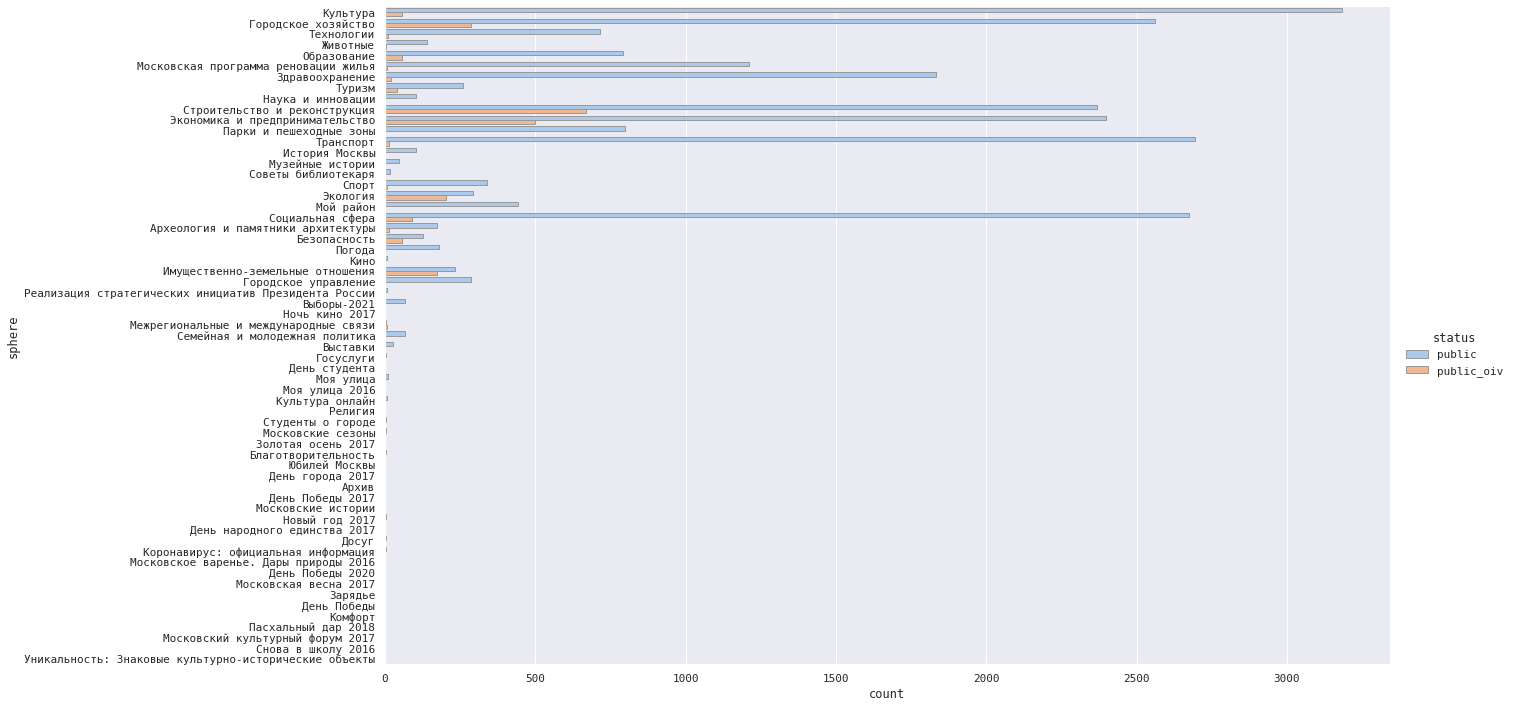

In [64]:
g = sns.catplot(y="sphere", hue="status", kind="count",
            palette="pastel", edgecolor=".6", 
            data=df_fin, height=10, aspect=2)

In [65]:
df_fin['sphere'].value_counts()[:15]

Культура                                3240
Строительство и реконструкция           3037
Экономика и предпринимательство         2900
Городское хозяйство                     2848
Социальная сфера                        2764
Транспорт                               2707
Здравоохранение                         1853
Московская программа реновации жилья    1217
Образование                              850
Парки и пешеходные зоны                  800
Технологии                               725
Экология                                 494
Мой район                                443
Имущественно-земельные отношения         408
Спорт                                    348
Name: sphere, dtype: int64

In [66]:
date_time_cols = ['date_time', 'created_at', 'published_at']

In [67]:
df_fin[date_time_cols] = df_fin[date_time_cols].apply(lambda col: pd.to_datetime(col))

In [68]:
df_fin['marker'] = [1 for i in range(df_fin.shape[0])]

### Дата публикации / срок актуальности

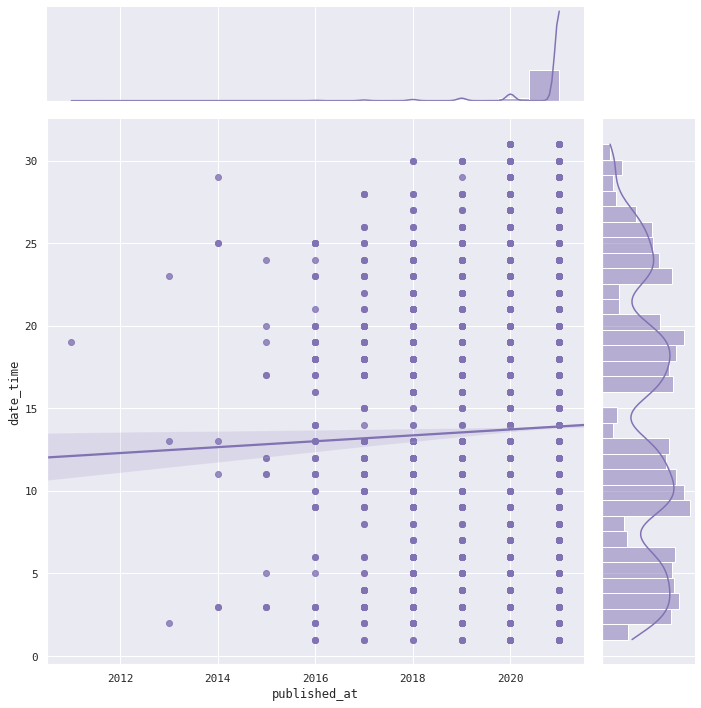

In [69]:
g = sns.jointplot(x=df_fin.published_at.dt.year,
                  y=df_fin.date_time.dt.day,
                  data=df_fin,
                  kind="reg",
                  truncate=False,
#                   xlim=(df_fin.created_at.min(), df_fin.created_at.max()), ylim=(df_fin.date_time.min(), df_fin.date_time.max()),
                  color="m",
                  height=10
                 )

среди просмотренных за август новостей есть достаточно много тех, которые были опубликованы несколько лет назад

In [70]:
df_fin.groupby(df_fin.published_at.dt.year)[['kind']].count()

,kind
published_at,
2011,1
2013,3
2014,7
2015,13
2016,75
2017,161
2018,296
2019,653
2020,1736


In [71]:
df_fin['time_alive'] = df_fin.date_time - df_fin.published_at

In [72]:
df_fin.groupby('sphere')['time_alive'].describe().sort_values(by='count', ascending=False)[:20]

,count,mean,std,min,25%,50%,75%,max
sphere,,,,,,,,
Культура,3240,144 days 08:41:49.213888892,309 days 22:40:18.042371456,0 days 00:00:19,0 days 02:49:31.250000,1 days 05:32:22.500000,110 days 02:37:44.250000,2932 days 00:27:40
Строительство и реконструкция,3037,83 days 04:55:17.861705630,246 days 17:59:34.965166468,0 days 00:00:13,0 days 02:15:52,0 days 19:41:31,22 days 01:24:42,2971 days 02:55:53
Экономика и предпринимательство,2900,67 days 05:59:12.114827586,173 days 14:29:38.921724034,0 days 00:00:22,0 days 02:26:18.250000,1 days 10:04:50.500000,37 days 10:26:53.250000,2356 days 23:23:13
Городское хозяйство,2848,74 days 11:12:02.721558988,231 days 23:47:47.211569112,0 days 00:00:10,0 days 02:20:45.250000,0 days 21:14:35.500000,15 days 08:41:54,3642 days 13:29:51
Социальная сфера,2764,90 days 05:18:19.037988422,225 days 13:40:27.495273152,0 days 00:00:11,0 days 02:34:09,1 days 22:38:13,61 days 00:27:11.500000,2433 days 00:57:55
Транспорт,2707,80 days 01:49:32.258958255,227 days 09:10:56.134393008,0 days 00:00:12,0 days 02:44:59.500000,1 days 00:58:29,35 days 19:57:48.500000,2510 days 22:36:10
Здравоохранение,1853,60 days 20:40:25.666486778,170 days 19:41:32.482585496,-3 days +09:59:56,0 days 02:09:27,1 days 08:34:58,37 days 11:47:23,2086 days 02:36:22
Московская программа реновации жилья,1217,34 days 21:36:50.036154478,113 days 03:38:01.835110064,0 days 00:00:12,0 days 02:28:41,0 days 21:47:19,8 days 20:32:55,1259 days 11:31:30
Образование,850,154 days 03:41:06.255294118,337 days 09:14:03.167033780,0 days 00:00:23,0 days 04:23:04.500000,6 days 18:31:01.500000,128 days 12:53:00.500000,2556 days 23:05:20


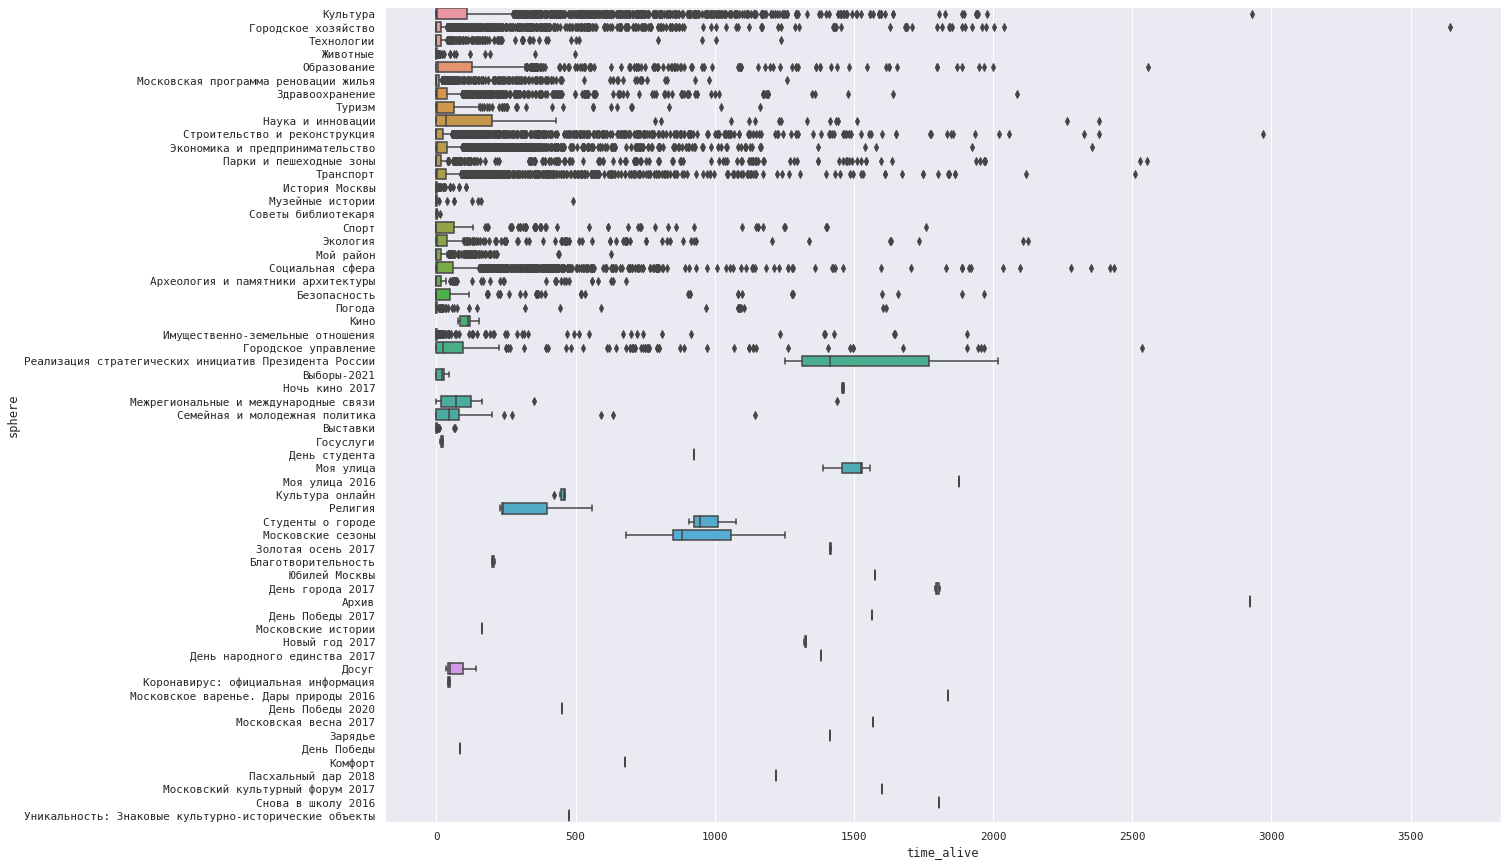

In [73]:
fig, ax = plt.subplots(figsize=(20, 15))
g = sns.boxplot(x=df_fin.time_alive.dt.days, y=df_fin.sphere, ax=ax)

##### Новости из некоторых категорий остаются актуальными вплоть до полугода. Возможно стоит учесть этот момент в модели.

In [74]:
popular_in = df_fin.groupby(['area_title', 'sphere'])[['marker']].count().sort_values(by='marker', ascending=False)

In [75]:
popular_in[:20]

,,marker
area_title,sphere,
Басманный,Культура,388
Арбат,Культура,362
Останкинский,Культура,194
Пресненский,Культура,188
Тверской,Культура,174
Отрадное,Городское хозяйство,135
Останкинский,Парки и пешеходные зоны,118
Хамовники,Культура,104
Якиманка,Культура,99


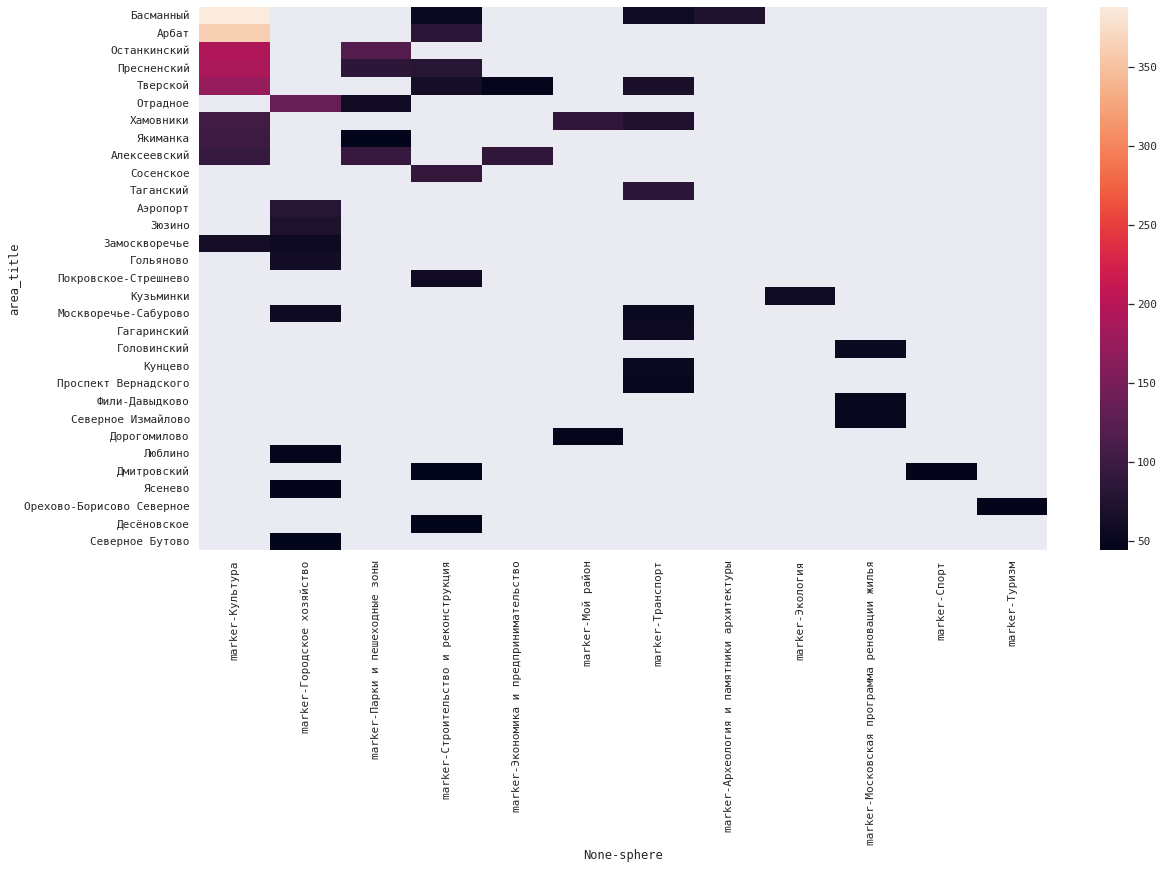

In [76]:
fig, ax = plt.subplots(figsize=(19,10))
ax = sns.heatmap(popular_in[:50].unstack())

##### жители центральных районов Москвы интересуются, например, культурой. в орехово-борисово и ясенево - спортом и туризмом. но не так сильно

In [77]:
df_fin['days_alive'] = df_fin.time_alive.apply(lambda d: d.days)

In [78]:
df_fin['hours_alive'] = df_fin.time_alive.astype("timedelta64[s]") / 60

In [79]:
df_fin['hours_alive'] = df_fin.hours_alive.round(1)

In [80]:
df_fin.tail()

,date_time,url_clean,user_id,news_id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label,area_title,district_title,marker,time_alive,days_alive,hours_alive
26441,2021-08-07 18:58:27,mos.ru/mayor/themes/332299/7538050/,278,7538050,2021-08-01 11:28:18,2021-08-01 11:33:00,public,Новости Мэра,ВДНХ отмечает 82-й день рождения,За семь лет отреставрировано 23 памятника куль...,"[реставрация, парки, ВДНХ, Сергей Собянин]",/mayor/themes/3299/7538050/,Культура,"[Культура, Парки и пешеходные зоны, Мой район,...",,NaN,NaN,1,6 days 07:25:27,6,9085.4
26442,2021-08-07 19:05:35,mos.ru/mayor/themes/231299/7553050/,278,7553050,2021-08-07 14:13:20,2021-08-07 14:29:00,public,Новости Мэра,Сергей Собянин: В Москве появится 11 профессио...,Мэр осмотрел строящееся футбольное поле размер...,"[благоустройство, строительство, Сергей Собяни...",/mayor/themes/4299/7553050/,Строительство и реконструкция,"[Строительство и реконструкция, Спорт, Мой рай...",,NaN,NaN,1,0 days 04:36:35,0,276.6
26443,2021-08-07 19:36:47,mos.ru/mayor/themes/2299/7549050/,278,7549050,2021-08-06 12:43:21,2021-08-06 13:08:00,public,Новости Мэра,Сергей Собянин открыл движение по новому путеп...,Магистраль свяжет Юго-Восточную хорду с Третьи...,"[путепроводы, хорды, Сергей Собянин, ЮВХ, стро...",/mayor/themes/2299/7549050/,Транспорт,"[Транспорт, Мой район, Комфорт]",,NaN,NaN,1,1 days 06:28:47,1,1828.8
26444,2021-08-07 22:41:32,mos.ru/mayor/themes/350299/7553050/,278,7553050,2021-08-07 14:13:20,2021-08-07 14:29:00,public,Новости Мэра,Сергей Собянин: В Москве появится 11 профессио...,Мэр осмотрел строящееся футбольное поле размер...,"[благоустройство, строительство, Сергей Собяни...",/mayor/themes/4299/7553050/,Строительство и реконструкция,"[Строительство и реконструкция, Спорт, Мой рай...",,NaN,NaN,1,0 days 08:12:32,0,492.5
26445,2021-08-08 10:06:25,mos.ru/news/item/94361073/,278,94361073,2021-08-07 14:42:47,2021-08-08 09:04:01,public,Новости,Портал «Наш город» помог решить более шести ты...,Чаще всего с помощью портала устраняли нарушен...,"[строительство, ЖКХ, обращения, Наш город, Але...",/news/item/94361073/,Строительство и реконструкция,"[Строительство и реконструкция, Технологии]",,NaN,NaN,1,0 days 01:02:24,0,62.4


In [81]:
# df_fin.drop(columns=['url']).to_json(os.path.join(BASE_DIR, 'data', 'combined_data.json'), orient='records', force_ascii=False)

In [ ]:
# %time pd.read_json(os.path.join(BASE_DIR, 'data', 'combined_data.json'))

In [ ]:
# %%time
# with open(os.path.join(BASE_DIR, 'data', 'combined_data.json'),'r') as file:
#     data = json.load(file)
#     n_data = pd.DataFrame(data)

In [84]:
df_fin = df_fin.sort_values(by='time_alive')

In [85]:
df_fin['n_views'] = df_fin.groupby('news_id')['marker'].cumsum()

In [86]:
df_fin.groupby('news_id')['marker'].cumsum()

24138    1
24139    1
4230     1
4386     1
11273    1
        ..
10604    1
9781     1
25980    1
13998    1
145      1
Name: marker, Length: 26442, dtype: int64

In [118]:
df_fin[df_fin.news_id == 94607073].sort_values(by='time_alive')

,date_time,url_clean,user_id,news_id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label,area_title,district_title,marker,time_alive,days_alive,hours_alive,n_views,rank
9883,2021-08-16 14:40:06,mos.ru/news/item/94607073/,98,94607073,2021-08-13 12:28:39,2021-08-16 14:28:38,public_oiv,Новости,Дом по реновации в Южном Медведкове облицуют д...,Высота двухсекционного дома составит 11 этажей...,"[СВАО, реновация, Сергей Кузнецов, Москомархит...",/news/item/94607073/,Московская программа реновации жилья,[Московская программа реновации жилья],,NaN,NaN,1,0 days 00:11:28,0,11.5,1,6.0
15209,2021-08-16 15:17:58,mos.ru/news/item/94607073/,159,94607073,2021-08-13 12:28:39,2021-08-16 14:28:38,public_oiv,Новости,Дом по реновации в Южном Медведкове облицуют д...,Высота двухсекционного дома составит 11 этажей...,"[СВАО, реновация, Сергей Кузнецов, Москомархит...",/news/item/94607073/,Московская программа реновации жилья,[Московская программа реновации жилья],,NaN,NaN,1,0 days 00:49:20,0,49.3,2,6.0
4606,2021-08-16 17:22:53,mos.ru/news/item/94607073/,38,94607073,2021-08-13 12:28:39,2021-08-16 14:28:38,public_oiv,Новости,Дом по реновации в Южном Медведкове облицуют д...,Высота двухсекционного дома составит 11 этажей...,"[СВАО, реновация, Сергей Кузнецов, Москомархит...",/news/item/94607073/,Московская программа реновации жилья,[Московская программа реновации жилья],,NaN,NaN,1,0 days 02:54:15,0,174.2,3,6.0


In [ ]:
df_fin[df_fin.news_id == 95079073].sort_values(by='time_alive').head()

In [88]:
median_views = df_fin.n_views.median()

In [89]:
mean_views = df_fin.n_views.mean()

In [90]:
std_dev = df_fin.n_views.std()

In [91]:
mean_views

10.783299296573633

In [92]:
std_dev

11.643530946541102

In [93]:
median_views

6.0

In [94]:
def get_rank(n_views, days_alive):
    if days_alive == 0:
        days_alive += 1
        if n_views < median_views:
            n_views = median_views
    return n_views / days_alive

In [95]:
df_fin['rank'] = df_fin.apply(lambda x: get_rank(x.n_views, x.days_alive), axis=1)

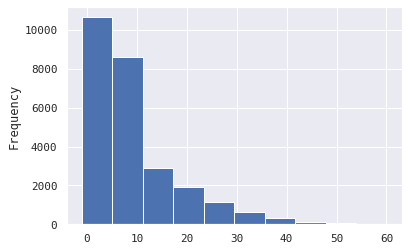

In [96]:
g = df_fin['rank'].plot(kind='hist')

In [105]:
df_fin[['news_id', 'rank', 'title', 'date_time', 'published_at', 'n_views', 'days_alive']].drop_duplicates(subset='news_id').sort_values(by='rank', ascending=False).head(20)

,news_id,rank,title,date_time,published_at,n_views,days_alive
16784,94702073,60.0,Москва поднялась на четыре позиции в рейтинге ...,2021-08-19 01:32:30,2021-08-17 09:01:00,60,1
15529,94061073,58.0,Открылась регистрация на онлайн-голосование на...,2021-08-03 08:05:59,2021-08-02 07:02:03,58,1
16770,7575050,57.0,Правительство Москвы рассмотрит проекты компле...,2021-08-19 01:29:48,2021-08-17 15:41:00,57,1
23486,7552050,56.0,Сергей Собянин: Павильоны «Здоровая Москва» во...,2021-08-10 23:35:46,2021-08-09 09:09:00,56,1
8589,94417073,56.0,В Москве начала работать онлайн-платформа «Кар...,2021-08-12 00:16:38,2021-08-10 07:03:00,56,1
1469,7572050,54.0,Большой Каменный мост полностью открыт после к...,2021-08-18 01:29:07,2021-08-16 13:16:00,54,1
26122,94634073,54.0,Кинопоказы на подводной лодке и уроки итальянс...,2021-08-17 14:23:41,2021-08-16 07:01:00,54,1
16481,7571050,54.0,Сергей Собянин представил главные находки моск...,2021-08-18 07:31:24,2021-08-16 09:01:00,54,1
22526,7574050,53.0,Сергей Собянин рассказал о развитии электротра...,2021-08-19 08:35:15,2021-08-17 09:06:00,53,1
18016,94419073,53.0,Лучшие в 2020-м. Рассказываем о победителях ко...,2021-08-11 17:05:23,2021-08-10 07:01:03,53,1


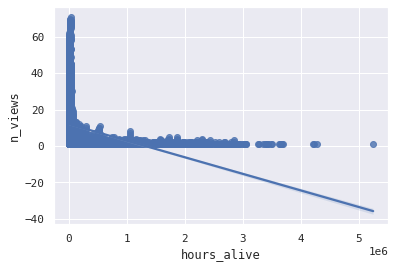

In [106]:
g = sns.regplot(x='hours_alive', y='n_views', data=df_fin)

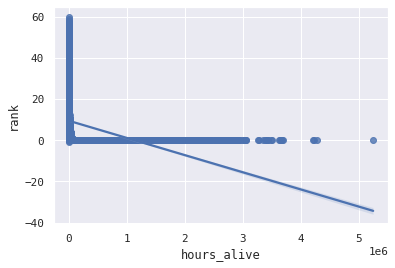

In [107]:
g = sns.regplot(x='hours_alive', y='rank', data=df_fin)

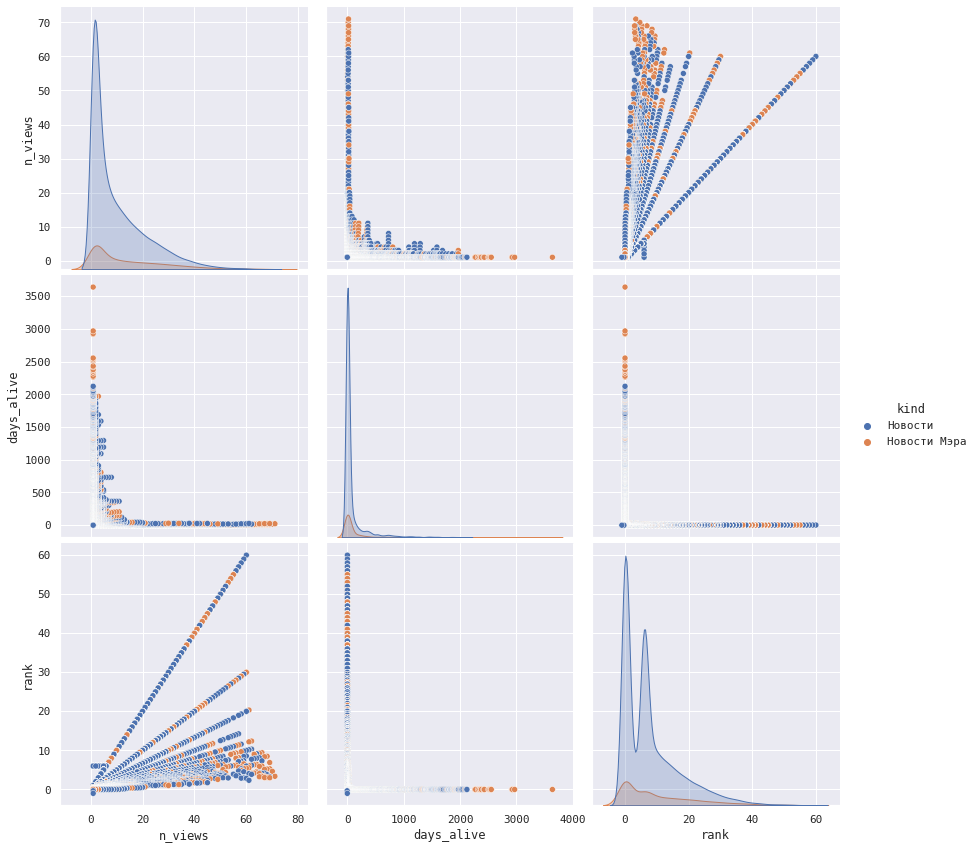

In [108]:
g = sns.pairplot(df_fin[['n_views', 'days_alive', 'rank', 'kind']], hue="kind", height=4)

In [109]:
df_fin = df_fin.sort_values(by='rank', ascending=False)

In [110]:
df_fin[df_fin.news_id == 7557050]

,date_time,url_clean,user_id,news_id,created_at,published_at,status,kind,title,preview_text,tags,url,sphere,spheres,label,area_title,district_title,marker,time_alive,days_alive,hours_alive,n_views,rank
23496,2021-08-11 01:40:55,mos.ru/mayor/themes/231299/7557050/,245,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,1 days 09:27:55,1,2007.9,51,51.000000
5625,2021-08-10 20:06:28,mos.ru/mayor/themes/231299/7557050/,46,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,1 days 03:53:28,1,1673.5,50,50.000000
9063,2021-08-10 15:29:51,mos.ru/mayor/themes/231299/7557050/,91,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,0 days 23:16:51,0,1396.8,49,49.000000
10883,2021-08-10 15:10:39,mos.ru/mayor/themes/2299/7557050/,112,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,0 days 22:57:39,0,1377.6,48,48.000000
13707,2021-08-10 14:29:02,mos.ru/mayor/themes/231299/7557050/,143,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,0 days 22:16:02,0,1336.0,47,47.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23662,2021-08-23 09:10:19,mos.ru/mayor/themes/2299/7557050/,249,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,13 days 16:57:19,13,19737.3,69,5.307692
24784,2021-08-23 08:36:45,mos.ru/mayor/themes/2299/7557050/,262,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,13 days 16:23:45,13,19703.8,68,5.230769
14203,2021-08-23 07:54:30,mos.ru/mayor/themes/2299/7557050/,150,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/7557050/,Транспорт,"[Транспорт, Мой район, Комфорт, Планы, Мой рай...",,NaN,NaN,1,13 days 15:41:30,13,19661.5,67,5.153846
16287,2021-08-25 13:47:44,mos.ru/mayor/themes/2299/7557050/,167,7557050,2021-08-09 15:47:58,2021-08-09 16:13:00,public,Новости Мэра,Открытие станции «Кунцевская» БКЛ улучшит тран...,Это позволит снизить нагрузку на Арбатско-Покр...,"[метро, Сергей Собянин, Крылатское, Московский...",/mayor/themes/2299/75570

In [116]:
df_fin[df_fin['rank'] > 1][['news_id', 'title', 'sphere', 'published_at', 'days_alive', 'n_views', 'rank']].drop_duplicates(subset='news_id').head(20)

,news_id,title,sphere,published_at,days_alive,n_views,rank
16784,94702073,Москва поднялась на четыре позиции в рейтинге ...,Экономика и предпринимательство,2021-08-17 09:01:00,1,60,60.0
15529,94061073,Открылась регистрация на онлайн-голосование на...,Технологии,2021-08-02 07:02:03,1,58,58.0
16770,7575050,Правительство Москвы рассмотрит проекты компле...,Строительство и реконструкция,2021-08-17 15:41:00,1,57,57.0
23486,7552050,Сергей Собянин: Павильоны «Здоровая Москва» во...,Здравоохранение,2021-08-09 09:09:00,1,56,56.0
8589,94417073,В Москве начала работать онлайн-платформа «Кар...,Культура,2021-08-10 07:03:00,1,56,56.0
1469,7572050,Большой Каменный мост полностью открыт после к...,Строительство и реконструкция,2021-08-16 13:16:00,1,54,54.0
26122,94634073,Кинопоказы на подводной лодке и уроки итальянс...,Культура,2021-08-16 07:01:00,1,54,54.0
16481,7571050,Сергей Собянин представил главные находки моск...,Культура,2021-08-16 09:01:00,1,54,54.0
37,94647073,Московские лифты начали оснащать бактерицидным...,Городское хозяйство,2021-08-16 07:01:04,1,53,53.0
18016,94419073,Лучшие в 2020-м. Рассказываем о победителях ко...,Строительство и реконструкция,2021-08-10 07:01:03,1,53,53.0


In [104]:
df_fin[df_fin.n_views > 10][['news_id', 'title', 'sphere', 'published_at', 'days_alive', 'n_views', 'rank']].drop_duplicates(subset='news_id').head(30)

,news_id,title,sphere,published_at,days_alive,n_views,rank
16784,94702073,Москва поднялась на четыре позиции в рейтинге ...,Экономика и предпринимательство,2021-08-17 09:01:00,1,60,60.0
15529,94061073,Открылась регистрация на онлайн-голосование на...,Технологии,2021-08-02 07:02:03,1,58,58.0
16770,7575050,Правительство Москвы рассмотрит проекты компле...,Строительство и реконструкция,2021-08-17 15:41:00,1,57,57.0
23486,7552050,Сергей Собянин: Павильоны «Здоровая Москва» во...,Здравоохранение,2021-08-09 09:09:00,1,56,56.0
8589,94417073,В Москве начала работать онлайн-платформа «Кар...,Культура,2021-08-10 07:03:00,1,56,56.0
1469,7572050,Большой Каменный мост полностью открыт после к...,Строительство и реконструкция,2021-08-16 13:16:00,1,54,54.0
26122,94634073,Кинопоказы на подводной лодке и уроки итальянс...,Культура,2021-08-16 07:01:00,1,54,54.0
16481,7571050,Сергей Собянин представил главные находки моск...,Культура,2021-08-16 09:01:00,1,54,54.0
22526,7574050,Сергей Собянин рассказал о развитии электротра...,Транспорт,2021-08-17 09:06:00,1,53,53.0
18016,94419073,Лучшие в 2020-м. Рассказываем о победителях ко...,Строительство и реконструкция,2021-08-10 07:01:03,1,53,53.0


In [122]:
df_fin.groupby(['user_id', 'news_id', 'title', 'sphere'])[['marker']].sum().sort_values(by='marker', ascending=False).head(30)

,,,,marker
user_id,news_id,title,sphere,
91,7557050,Открытие станции «Кунцевская» БКЛ улучшит транспортную доступность нескольких районов у МКАД,Транспорт,3
37,7543050,"По высокоскоростной железнодорожной магистрали из Москвы в Санкт-Петербург можно будет доехать за 2,5 часа",Транспорт,2
35,7604050,Фестиваль «Цветочный джем» пройдет в Москве с 1 сентября по 1 октября,Парки и пешеходные зоны,2
46,7557050,Открытие станции «Кунцевская» БКЛ улучшит транспортную доступность нескольких районов у МКАД,Транспорт,2
237,7595050,Здание МИСиС на Ленинском проспекте отреставрируют,Мой район,2
3,7579050,Сергей Собянин рассказал о появлении новых зеленых и пешеходных зон в СЗАО,Городское хозяйство,2
108,7559050,Сергей Собянин утвердил проект благоустройства территории у станций МЦД-2 Бутово и Щербинка,Транспорт,2
46,7536050,Более сотни знаковых мест и 20 улиц благоустроят в столице до конца года,Городское хозяйство,2
3,7601050,В этом году в столице будет построено более 80 километров дорог,Транспорт,2


In [126]:
df_fin.groupby(['user_id', 'sphere', 'title'])[['marker']].sum().sort_values(by='marker', ascending=False).head(30)

marker
user_id sphere                               title                                                     
211     Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса           19
64      Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса           19
188     Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            5
42      Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            5
244     Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            5
204     Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            5
64      Здравоохранение                      Оперштаб сообщил о новых случаях COVID-19                5
                                             Оперштаб сообщил о новых случаях COVID-19 в Москве       4
211     Здравоохранение                      Оперштаб сообщил о новых случаях COVID-19                3
91      Транспорт                            Открытие станции «Кунцевская» БКЛ улучшит транс...       3
211     Здравоохранение                      Оперштаб сообщил о новых случаях COVID-19 в Москве       3
221     Экология                             Уровень загрязнения воздуха в Москве 30 июля 20...       3
75      Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            3
64      Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса в...       2
92      Московская программа реновации жилья Более пяти миллионов квадратных метров жилья ст...       2
237     Транспорт                            В этом году в столице будет построено более 80 ...       2
227     Образование                          Московские школьники завоевали три золотые меда...       2
131     Культура                             В Сретенском монастыре восстановят уникальные ф...       2
222     Экология                             Уровень загрязнения воздуха в Москве 05 августа...       2
86      Строительство и реконструкция        Сергей Собянин: В Москве появится 11 профессион...       2
156     Городское хозяйство                  Более сотни знаковых мест и 20 улиц благоустроя...       2
212     Туризм                               Партнеры сервиса Russpass получили доступ к отк...       2
100     Транспорт                            По высокоскоростной железнодорожной магистрали ...       2
112     Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            2
64      Здравоохранение                      Оперштаб сообщил о новых случаях коронавирусной...       2
222     Экология                             Уровень загрязнения воздуха в Москве 30 июля 20...       2
46      Транспорт                            Восточный вокзал в составе ТПУ «Черкизово» откр...       2
188     Туризм                               В Москве проведут конкурс на присуждение турист...       2
187     Здравоохранение                      Оперштаб сообщил о новых случаях коронавируса            2
237     Транспорт                            Сергей Собянин рассказал о планах развития ТПУ ...       2